# `ezpq` Examples

In [1]:
%matplotlib inline

In [2]:
import ezpq

In [3]:
import os
import time
import random
import logging as log
logger = log.getLogger()
logger.setLevel(log.INFO)
# logger.setLevel(log.DEBUG) # uncomment to view verbose output

In [4]:
import pandas as pd
from datetime import datetime

In [5]:
# Context manager to time functions
class MyTimer():
    '''https://www.blog.pythonlibrary.org/2016/05/24/python-101-an-intro-to-benchmarking-your-code/'''
    def __init__(self):
        self.start = time.time()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = round(end - self.start, 3)
        msg = 'Runtime: {time}'
        print(msg.format(time=runtime))

## Elementary example

I'll start with a step-by-step example to illustrate the basic operations. The code below is what we want to optimize. It simply loops 10 times, sleeping 1 second each time, for a total of 10 seconds.

```python
for _ in range(10):
    time.sleep(1)
```

Create the Queue with *n* workers.

In [6]:
Q = ezpq.Queue(n_workers=5)

Put jobs in the Queue.

In [7]:
for _ in range(10):
    Q.put(time.sleep, 1)

size() will count all jobs in the waiting, working, and completed queues.

In [8]:
Q.size()

10

Create a list to store job data (runtime and output).

In [9]:
results = list()

`get()` is used to pop the highest priority job from the *completed* queue. The result must be stored or it will be lost.

When `poll` > 0 and no output is available, the operation will wait for the next job to finish.

In [10]:
done = Q.get(poll=0.05) # get() returns a dict

results.append(done) # append dictionary to results list.

Count remaining jobs after the operation above.

In [11]:
Q.size()

8

`collect()` is used to repeatedly `get()` all completed jobs.

`collect()` does not support the `poll` parameter;

Instead, wait for all running and queued jobs to complete with `wait()` before calling `collect()`.

In [12]:
Q.wait()

done_list = Q.collect() # collect() returns a list

results.extend(done_list) # extend result list 

Verify no jobs remain.

In [13]:
Q.size()

0

Dispose of the `ezpq`. This will ensure all jobs are stopped and data is discarded.

In [14]:
Q.dispose()

Now, inspect a single job result.

In [15]:
results[0]

{'id': 1,
 'name': 1,
 'priority': 100,
 'timeout': 0,
 'function': 'sleep',
 'args': 1,
 'kwargs': None,
 'submitted': datetime.datetime(2018, 12, 14, 1, 21, 38, 115568),
 'started': datetime.datetime(2018, 12, 14, 1, 21, 38, 119053),
 'ended': datetime.datetime(2018, 12, 14, 1, 21, 39, 127767),
 'processed': datetime.datetime(2018, 12, 14, 1, 21, 39, 230335),
 'exitcode': 0,
 'cancelled': False,
 'runtime': 1.008713960647583,
 'output': None,
 'callback': None}

Create a pandas dataframe for a grid view of the results.

In [16]:
df = pd.DataFrame(results)

df.head()

,args,callback,cancelled,ended,exitcode,function,id,kwargs,name,output,priority,processed,runtime,started,submitted,timeout
0,1,None,False,2018-12-14 01:21:39.127767,0,sleep,1,None,1,None,100,2018-12-14 01:21:39.230335,1.008714,2018-12-14 01:21:38.119053,2018-12-14 01:21:38.115568,0
1,1,None,False,2018-12-14 01:21:39.131715,0,sleep,2,None,2,None,100,2018-12-14 01:21:39.230498,1.007055,2018-12-14 01:21:38.124660,2018-12-14 01:21:38.119448,0
2,1,None,False,2018-12-14 01:21:39.137062,0,sleep,3,None,3,None,100,2018-12-14 01:21:39.230640,1.007642,2018-12-14 01:21:38.129420,2018-12-14 01:21:38.125118,0
3,1,None,False,2018-12-14 01:21:39.141779,0,sleep,4,None,4,None,100,2018-12-14 01:21:39.230781,1.007788,2018-12-14 01:21:38.133991,2018-12-14 01:21:38.129805,0
4,1,None,False,2018-12-14 01:21:39.146661,0,sleep,5,None,5,None,100,2018-12-14 01:21:39.230986,1.008201,2018-12-14 01:21:38.138460,2018-12-14 01:21:38.134381,0


Lastly, visualize the steps.

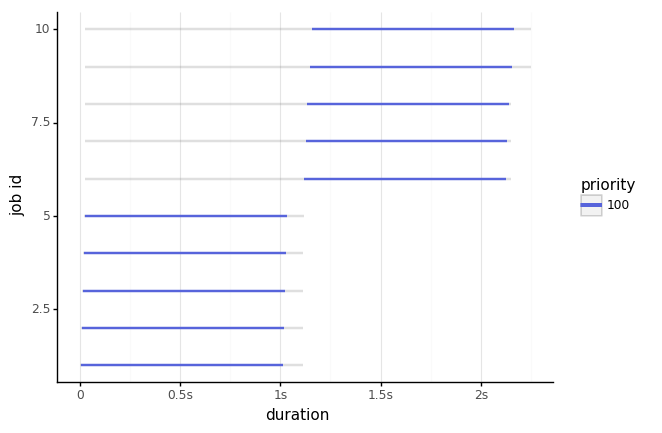

<ggplot: (305242120)>

In [17]:
ezpq.Plot(results).build()

In the chart above, the colored lines overlap because the jobs were run in parallel. Contrast that with the following example using serial processing.

## Serial processing

Below, the code is much more concise. However, the `ezpq.Queue` has only 1 worker. This is equivalent to having no concurrency at all, and instead performing each operation after another.

In [18]:
with ezpq.Queue(n_workers=1) as Q: # create an ezpq.Queue() with 1 workers.    
    for i in range(3): # create 3 jobs, each sleeping for 1 second.
        Q.put(function=time.sleep, args=1)
    
    Q.wait() # wait for all jobs to complete.
    
    results = Q.collect() # collect completed jobs from queue.
    
df = pd.DataFrame(results)

df.head()

,args,callback,cancelled,ended,exitcode,function,id,kwargs,name,output,priority,processed,runtime,started,submitted,timeout
0,1,None,False,2018-12-14 01:21:43.490321,0,sleep,1,None,1,None,100,2018-12-14 01:21:43.510847,1.007372,2018-12-14 01:21:42.482949,2018-12-14 01:21:42.480392,0
1,1,None,False,2018-12-14 01:21:44.523924,0,sleep,2,None,2,None,100,2018-12-14 01:21:44.548645,1.008899,2018-12-14 01:21:43.515025,2018-12-14 01:21:42.483390,0
2,1,None,False,2018-12-14 01:21:45.559968,0,sleep,3,None,3,None,100,2018-12-14 01:21:45.586352,1.008192,2018-12-14 01:21:44.551776,2018-12-14 01:21:42.483526,0


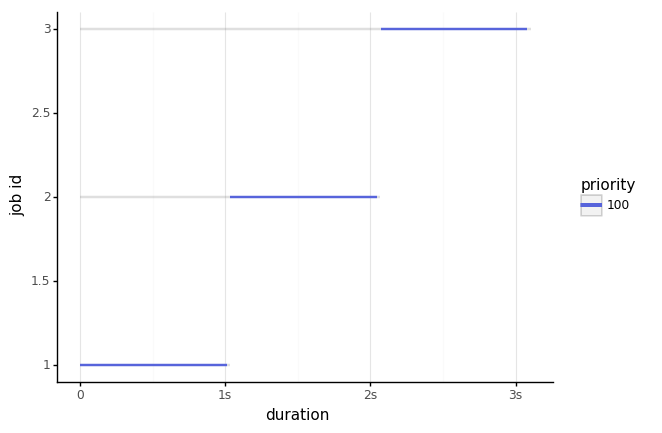

<ggplot: (291551194)>

In [19]:
# visualize the steps.
ezpq.Plot(results).build()

## More examples

Shared parameters; adjust as desired.

In [20]:
n_workers = 10 # number of workers to process the queue.
n_inputs  = 50 # number of inputs to the queue.
job_time  = 1  # number of seconds each input will 'sleep'

---

In [21]:
with ezpq.Queue(n_workers=n_workers) as Q: # create an ezpq.Queue() with 10 workers.    
    for i in range(n_inputs): # create 50 jobs, each sleeping for 1 second.
        Q.put(function=time.sleep, args=job_time)
    
    Q.wait() # wait for all jobs to complete.
    
    results = Q.collect() # collect completed jobs from queue.
    
df = pd.DataFrame(results)

df.head()

,args,callback,cancelled,ended,exitcode,function,id,kwargs,name,output,priority,processed,runtime,started,submitted,timeout
0,1,None,False,2018-12-14 01:21:47.275355,0,sleep,1,None,1,None,100,2018-12-14 01:21:47.300847,1.008816,2018-12-14 01:21:46.266539,2018-12-14 01:21:46.263539,0
1,1,None,False,2018-12-14 01:21:47.278906,0,sleep,2,None,2,None,100,2018-12-14 01:21:47.301042,1.007733,2018-12-14 01:21:46.271173,2018-12-14 01:21:46.266918,0
2,1,None,False,2018-12-14 01:21:47.285168,0,sleep,3,None,3,None,100,2018-12-14 01:21:47.301279,1.009126,2018-12-14 01:21:46.276042,2018-12-14 01:21:46.271623,0
3,1,None,False,2018-12-14 01:21:47.290123,0,sleep,4,None,4,None,100,2018-12-14 01:21:47.301468,1.008680,2018-12-14 01:21:46.281443,2018-12-14 01:21:46.276459,0
4,1,None,False,2018-12-14 01:21:47.295000,0,sleep,5,None,5,None,100,2018-12-14 01:21:47.301622,1.008244,2018-12-14 01:21:46.286756,2018-12-14 01:21:46.281916,0


/Users/donald/envs/mypy36/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/Users/donald/envs/mypy36/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: imgs/50x1x10.png
  warn('Filename: {}'.format(filename))


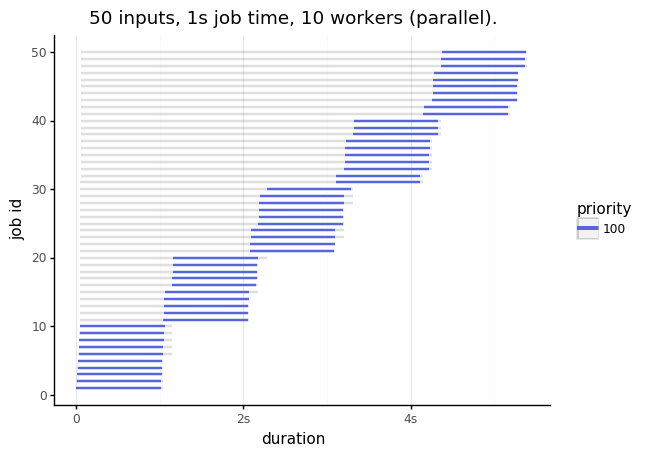

<ggplot: (-9223372036547189304)>

In [22]:
title='{} inputs, {}s job time, {} workers (parallel).'.format(n_inputs, job_time, n_workers)

plt = ezpq.Plot(results, title=title).build()

plt.save('imgs/{}x{}x{}.png'.format(n_inputs, job_time, n_workers))
plt

## Job Priority

Jobs are prioritized by (1) custom priority and (2) arrival time. By using a priority queue for both pending and completed jobs, you can be sure that higher priority jobs are executed and retrieved sooner.

The default priority value is 100. Lower values take higher priority.

/Users/donald/envs/mypy36/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/Users/donald/envs/mypy36/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: imgs/100x1x10_priority.png
  warn('Filename: {}'.format(filename))


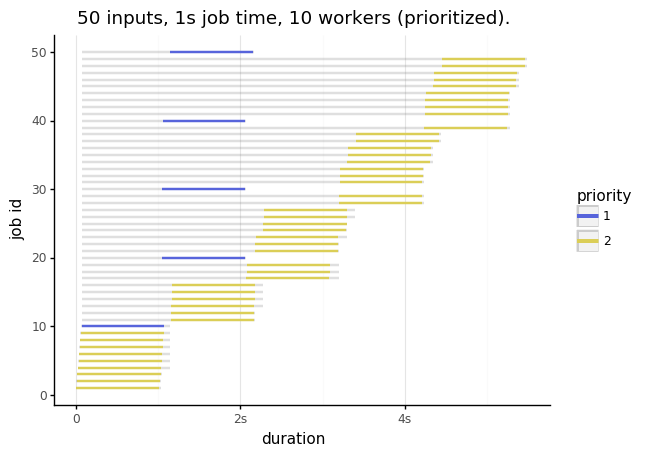

<ggplot: (-9223372036546690037)>

In [23]:
with ezpq.Queue(n_workers=n_workers) as Q:

    for i in range(n_inputs):
        Q.put(function=time.sleep, args=job_time,
              priority=int((i+1) % 10 != 0)+1) # prioritize numbers divisible by ten.

    Q.wait()

    results = Q.collect()

title = '{} inputs, {}s job time, {} workers (prioritized).'.format(n_inputs, job_time, n_workers)

plt = ezpq.Plot(results, title=title, color_by='priority').build()

plt.save('imgs/100x1x10_priority.png')
plt

Notice how some lower priority 2 jobs are processed before the higher priority 1 jobs. That is because those priority 2 jobs arrived when there were no priority 1 jobs, so they were started and completed first.

/Users/donald/envs/mypy36/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/Users/donald/envs/mypy36/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: imgs/100x1x10_priority.png
  warn('Filename: {}'.format(filename))


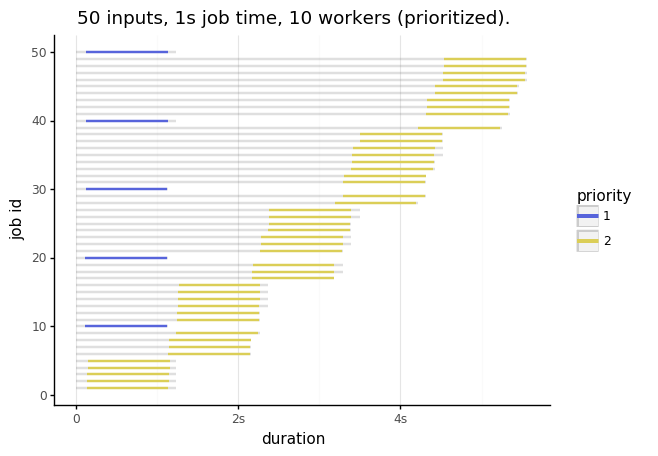

<ggplot: (-9223372036547322750)>

In [24]:
with ezpq.Queue(n_workers=n_workers, auto_start=False) as Q: # suppress auto_start (not required).

    for i in range(n_inputs):
        
        Q.put(function=time.sleep, args=job_time,
              priority=int(bool((i+1) % 10 != 0))+1) # prioritize numbers divisible by ten.
        
    Q.start() # start *after* adding all jobs to queue.

    Q.wait()

    results = Q.collect()

title = '{} inputs, {}s job time, {} workers (prioritized).'.format(n_inputs, job_time, n_workers)
plt = ezpq.Plot(results, title=title, color_by='priority').build()

plt.save('imgs/100x1x10_priority.png')
plt

## Threads

By default, `ezpq.Queue` uses `multiprocessing.Process` to spawn new jobs. However, you can use `threading.Thread` instead by specifying `job_runner=Thread` when creating the Queue. Some of the differences between processes and threads are explained [here](https://medium.com/@bfortuner/python-multithreading-vs-multiprocessing-73072ce5600b).

> Note that, inherently, `Thread` loses the ability to enforce a timeout, to kill jobs, or to obtain exit codes.

Aside from that, there's no difference in how you interact with ezpq.

In addition to using Threads, the example below varies the job time between 0-2 seconds.

/Users/donald/envs/mypy36/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/Users/donald/envs/mypy36/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: imgs/100xNx10.png
  warn('Filename: {}'.format(filename))


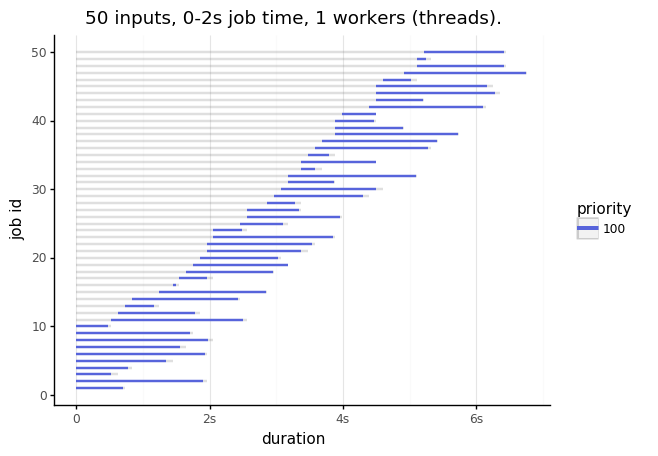

<ggplot: (309041237)>

In [25]:
from threading import Thread

with ezpq.Queue(n_workers=n_workers, job_runner=Thread) as Q:

    for i in range(n_inputs):
        sleep_sec = random.randint(0, job_time*2000) / 1000 # sleep for random time between 0-2s (avg=1s).
        
        Q.put(function=time.sleep, args=sleep_sec)

    Q.wait()

    results = Q.collect()

title = '{} inputs, 0-2s job time, {} workers (threads).'.format(n_inputs, job_time, n_workers)
plt = ezpq.Plot(results, title=title).build()

plt.save('imgs/100xNx10.png')
plt

## Timeout

> Recall that you can only use timeout when using processes, not threads.

In [26]:
n_inputs = 50
job_time = 1

/Users/donald/envs/mypy36/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/Users/donald/envs/mypy36/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: imgs/50xNx10_timeouts.png
  warn('Filename: {}'.format(filename))


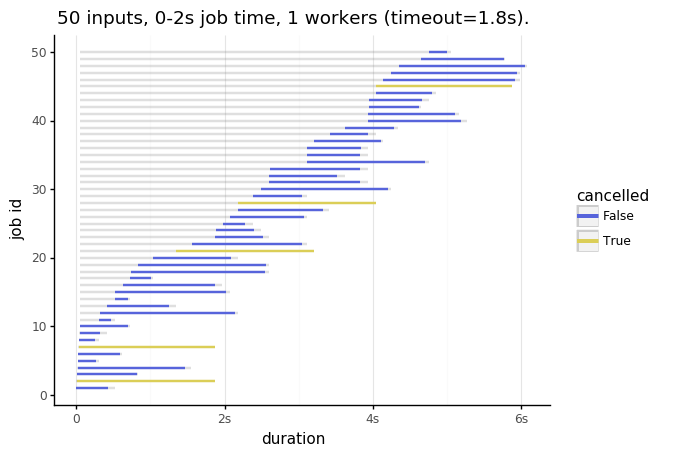

<ggplot: (308544064)>

In [27]:
with ezpq.Queue(n_workers=n_workers) as Q:

    for i in range(n_inputs):
        sleep_sec = random.randint(0, job_time*2000) / 1000 # sleep between 0s and 2s (avg=1s).

        Q.put(function=time.sleep, args=sleep_sec,
              timeout=job_time*1.8) # 1.8 < 2; timeout will occur on ~10% of jobs.

    Q.wait()

    results = Q.collect()
    
title = '{} inputs, 0-2s job time, {} workers (timeout=1.8s).'.format(n_inputs, job_time, n_workers)

plt = ezpq.Plot(results, color_by='cancelled', title=title).build()

plt.save('imgs/{}xNx{}_timeouts.png'.format(n_inputs, n_workers))
plt

## Logging

Writing to a log is as simple as adding `log_file='/path/to/file.csv'`. 

The example below illustrates a simply real-world use case. The goal is to obtain the total count and size of files within various folders. One process will be spawned to enumerate each folder. By doing so in parallel, the entire operation only takes as long as the single-most long operation.

Define the function to enumerate the files.

In [39]:
import os, fnmatch
def enum_files(path, pattern):
    '''https://stackoverflow.com/a/1724723'''
    n, size = 0, 0
    for root, dirs, files in os.walk(path, followlinks=True):
        for name in files:
            if pattern is None or fnmatch.fnmatch(name, pattern):
                n += 1
                size += os.path.getsize( os.path.join(root, name) )
                
    return (n, size)

root_dir = os.environ['HOME']

include_dirs = [os.path.join(root_dir, x)
                for x in ['bin', 'Desktop', 'Documents', 'Downloads', 'Music', 'Pictures']]

In [40]:
log_file = 'ezpq_log.csv'

# first, remove existing log file.
if os.path.exists(log_file):
    os.unlink(log_file)

Each result will be written to a CSV file and discarded. Afterward, we'll read the CSV back in and draw a plot.

Notice there is no call to `get()` or `collect()`. Because `auto_remove=True`, jobs are discarded; there is no completed queue to pull from.

In [41]:
with ezpq.Queue(n_workers = len(include_dirs),
                log_file=log_file, auto_remove=True) as Q:

    for path in include_dirs:
        Q.put(name=path,
              function=enum_files,
              kwargs={'path': path, 'pattern': '*'})

    Q.wait()

Read the CSV file back in with pandas.

In [42]:
date_cols = ['submitted', 'started', 'ended', 'processed']

results

df = pd.read_csv(log_file, parse_dates=date_cols)

df.head()

,id,name,priority,timeout,function,args,kwargs,submitted,started,ended,processed,exitcode,cancelled,runtime,output,callback
0,2,/Users/donald/Desktop,100,0,enum_files,NaN,"{'path': '/Users/donald/Desktop', 'pattern': '*'}",2018-12-14 01:35:12.438547,2018-12-14 01:35:12.443337,2018-12-14 01:35:12.453491,2018-12-14 01:35:12.539101,0,False,0.010154,"(13, 220849528)",NaN
1,5,/Users/donald/Music,100,0,enum_files,NaN,"{'path': '/Users/donald/Music', 'pattern': '*'}",2018-12-14 01:35:12.454567,2018-12-14 01:35:12.460151,2018-12-14 01:35:12.475792,2018-12-14 01:35:12.541006,0,False,0.015641,"(57, 3311076)",NaN
2,1,/Users/donald/bin,100,0,enum_files,NaN,"{'path': '/Users/donald/bin', 'pattern': '*'}",2018-12-14 01:35:12.434811,2018-12-14 01:35:12.438180,2018-12-14 01:35:12.576317,2018-12-14 01:35:12.639028,0,False,0.138137,[Errno 2] No such file or directory: '/Users/d...,NaN
3,4,/Users/donald/Downloads,100,0,enum_files,NaN,"{'path': '/Users/donald/Downloads', 'pattern':...",2018-12-14 01:35:12.448823,2018-12-14 01:35:12.454176,2018-12-14 01:35:13.614857,2018-12-14 01:35:13.656294,0,False,1.160681,"(38037, 6356471918)",NaN
4,3,/Users/donald/Documents,100,0,enum_files,NaN,"{'path': '/Users/donald/Documents', 'pattern':...",2018-12-14 01:35:12.443739,2018-12-14 01:35:12.448398,2018-12-14 01:35:14.153907,2018-12-14 01:35:14.161876,0,False,1.705509,"(62508, 15648953778)",NaN


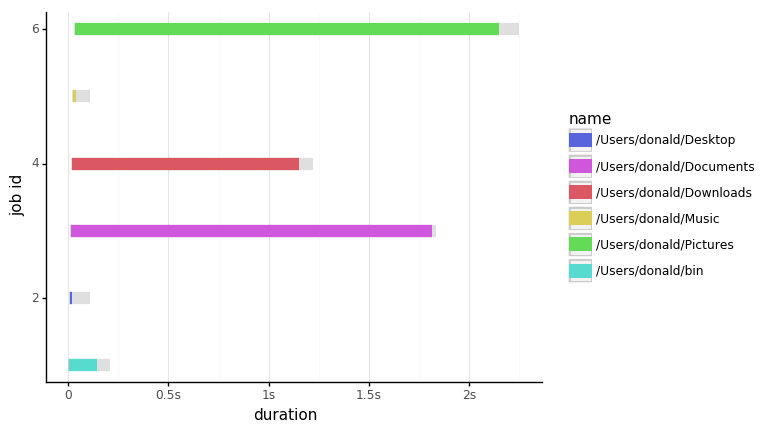

<ggplot: (308740307)>

In [38]:
# ezpq.Plot requires a dictionary of job data records.
records = df.to_dict(orient='records')

plt = ezpq.Plot(records, color_by='name', bar_width=5).build()

# plt.save('...')
plt

## Callback

If instantiated with a callback, `ezpq.Queue` will pass a dictionary of job data as the single argument to the callback function. It does this synchronously, so the callback must not take too much time. I may make the callback asynchronous in the future.

In [54]:
def slow_callback(x):
    time.sleep(0.5)

In [55]:
with ezpq.Queue(n_workers=n_workers, callback=slow_callback, poll=0.5) as Q:
    for _ in range(n_inputs):
        Q.put(time.sleep, 1)
    Q.wait()
    results = Q.collect()

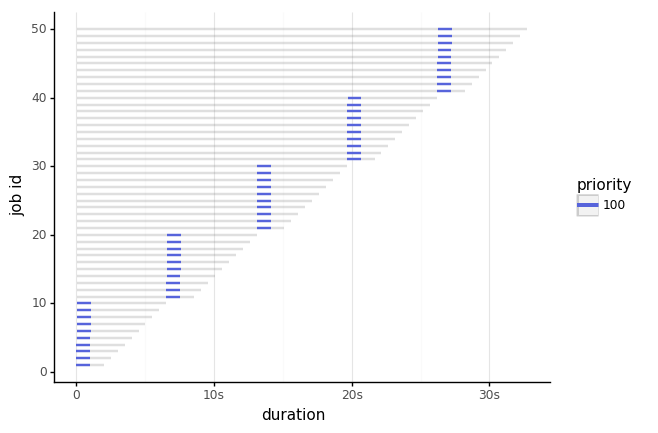

<ggplot: (-9223372036546741984)>

In [56]:
ezpq.Plot(results).build()